<a href="https://colab.research.google.com/github/MrOnie/DeepLearning/blob/master/PectoralRemovalSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pectoral Removal

---
**For a better experience (GUI) ⇧ open in Colab ⇧ or go to the original [link](https://colab.research.google.com/drive/1awOrasGu9QSf94RCnk11oPP2VV_iSAsp#scrollTo=SKP1ruoSBt6f).**

---

System to:
* Remove pectoral muscle from mammography using opencv
* Segment the mammography without pectoral muscle using k-means or threshold

Based on "[Deep Learning to Improve Breast Cancer Detection on Screening Mammography](https://github.com/lishen/end2end-all-conv)" project by Li Shen.

**All the required data is available at the [link](https://drive.google.com/drive/folders/1olpt4BrCQTmKrMSYQqeBtHQzUApBzAg8?usp=sharing) and must be copied to the root of the personal Google Drive account.**

## Drive vinculation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [2]:
import cv2 # Open CV
import matplotlib.pyplot as plt
import numpy as np
import os

path = '/content/drive/My Drive/Mini-mias/'

## Functions

In [3]:
def select_largest_obj(img_bin, lab_val=255, fill_holes=False, 
                       smooth_boundary=False, kernel_size=15):
  '''Select the largest object from a binary image and optionally
  fill holes inside it and smooth its boundary.
  Args:
    img_bin(2D array): 2D numpy array of binary image.
    lab_val([int]): integer value used for the label of the largest 
                    object. Default is 255.
    fill_holes([boolean]): whether fill the holes inside the largest 
                           object or not. Default is false.
    smooth_boundary([boolean]): whether smooth the boundary of the 
                                largest object using morphological 
                                opening or not. Default is false.
    kernel_size([int]): the size of the kernel used for morphological 
                        operation.
  '''
  n_labels, img_labeled, lab_stats, centroids = cv2.connectedComponentsWithStats(
    img_bin, connectivity=8, ltype=cv2.CV_32S)
  largest_obj_lab = np.argmax(lab_stats[1:, 4]) + 1
  centroid_lo = centroids[largest_obj_lab]
  largest_mask = np.zeros(img_bin.shape, dtype=np.uint8)
  largest_mask[img_labeled == largest_obj_lab] = lab_val
  if fill_holes:
    bkg_locs = np.where(img_labeled == 0)
    bkg_seed = (bkg_locs[0][0], bkg_locs[1][0])
    img_floodfill = largest_mask.copy()
    h_, w_ = largest_mask.shape
    mask_ = np.zeros((h_ + 2, w_ + 2), dtype=np.uint8)
    cv2.floodFill(img_floodfill, mask_, seedPoint=bkg_seed, newVal=lab_val)
    holes_mask = cv2.bitwise_not(img_floodfill)  # mask of the holes.
    largest_mask = largest_mask + holes_mask
  if smooth_boundary:
    kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_OPEN, kernel_)  
  return largest_mask, centroid_lo

def select_pect(pect_binary_thres, lab_val=255):
  largest_object, centroid = select_largest_obj(pect_binary_thres, lab_val=255, 
                                                fill_holes=True, smooth_boundary=False)
  snd_largest_object, snd_centroid = select_largest_obj(pect_binary_thres-largest_object, 
                                                        lab_val=255, fill_holes=True, smooth_boundary=False)
  center = pect_binary_thres.shape[0]/2
  if np.abs(centroid-center)[0] > np.abs(snd_centroid-center)[0]:# and np.abs(centroid-center)[1] > np.abs(snd_centroid-center)[1]:
    pect_mask_init = largest_object
  else:
    pect_mask_init = snd_largest_object
  return pect_mask_init


def pectoral_removal(original_image, pect_high_inten_thres = 200):
  # Filter Selection **********************************
  mammo_filtered, _, _ = filter_selection(original_image)
  # Median filter
  #mammo_med_blurred = cv2.medianBlur(original_image, 3)  # <<= tune

  # Threshold
  global_threshold = 18  # from Nagi thesis. <<= tune
  _, mammo_binary = cv2.threshold(mammo_filtered, global_threshold, 
                                  maxval=255, type=cv2.THRESH_BINARY)

  # Suppr
  mammo_breast_mask, _ = select_largest_obj(mammo_binary, lab_val=255, fill_holes=False, 
                                            smooth_boundary=True, kernel_size=15)  # <<= tune
  mammo_arti_suppr = cv2.bitwise_and(original_image, mammo_breast_mask)

  # Enhancement
  clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
  mammo_breast_equ = clahe.apply(mammo_arti_suppr)
  #mammo_breast_equ = cv2.equalizeHist(mammo_arti_suppr) # Instead of CLAHE
  
  # Threshold
  _, pect_binary_thres = cv2.threshold(mammo_breast_equ, pect_high_inten_thres, # <<= tune!!! 200
                                       maxval=255, type=cv2.THRESH_BINARY)

  # Select Pect
  pect_mask_init = select_pect(pect_binary_thres, lab_val=255)

  pect_marker_img = np.zeros(pect_mask_init.shape, dtype=np.int32)
  # Sure foreground - Morphology
  pect_mask_init, _ = select_largest_obj(pect_mask_init, lab_val=255,
                                         fill_holes=True, smooth_boundary=False)
  kernel_ = np.ones((3, 3), dtype=np.uint8)  # <<= tune
  n_erosions = 7  # <<= tune
  pect_mask_eroded = cv2.erode(pect_mask_init, kernel_, iterations=n_erosions)
  pect_marker_img[pect_mask_eroded > 0] = 255
  # Sure background - breast.
  n_dilations = 7  # <<= tune
  pect_mask_dilated = cv2.dilate(pect_mask_init, kernel_, iterations=n_dilations)
  pect_marker_img[pect_mask_dilated == 0] = 128
  # Sure background - background.
  pect_marker_img[mammo_breast_mask == 0] = 64

  # Watershed + Equalized
  mammo_breast_equ_3c = cv2.cvtColor(mammo_breast_equ, cv2.COLOR_GRAY2BGR)
  #cv2.watershed(mammo_breast_equ_3c, pect_marker_img)
  pect_mask_watershed = pect_marker_img.copy()
  mammo_breast_equ_3c[pect_mask_watershed == -1] = (0, 0, 255)
  pect_mask_watershed[pect_mask_watershed == -1] = 0

  # Remove
  breast_only_mask = pect_mask_watershed.astype(np.uint8)
  breast_only_mask[breast_only_mask != 128] = 0
  breast_only_mask[breast_only_mask == 128] = 255
  kn_size = 25  # <<= tune
  kernel_ = np.ones((kn_size, kn_size), dtype=np.uint8)
  breast_only_mask_smo = cv2.morphologyEx(breast_only_mask, cv2.MORPH_OPEN, kernel_)
  image_wo_pectoral = cv2.bitwise_and(mammo_breast_equ, breast_only_mask_smo)

  # Plot
  fig,axes = plt.subplots(2, 2)
  fig.set_size_inches([9, 9])
  axes[0][0].imshow(original_image, cmap='gray')
  axes[0][0].title.set_text('Original Image')
  axes[0][1].imshow(pect_binary_thres, cmap='gray')
  axes[0][1].title.set_text('Binary Threshold (pect_high_inten_thres)')
  axes[1][0].imshow(breast_only_mask_smo, cmap='gray')
  axes[1][0].title.set_text('Largest Object Mask (index)')
  axes[1][1].imshow(image_wo_pectoral, cmap='gray')
  axes[1][1].title.set_text('Image Without Pectoral Muscle')
  return pect_binary_thres, image_wo_pectoral, breast_only_mask_smo

def filter_selection(original_image, plot=False):
  mammo_median = cv2.medianBlur(img, 5)
  mammo_gaussian = cv2.GaussianBlur(img,(5,5),0)
  #kernel = np.ones((5,5)) / 25
  xdir_gauss = cv2.getGaussianKernel(5, 1.0)
  kernel = np.multiply(xdir_gauss.T, xdir_gauss)
  mammo_wiener = wiener_filter(img, kernel)

  psnr_m, mse_m = PSNR(img, mammo_median)
  psnr_g, mse_g = PSNR(img, mammo_gaussian)
  psnr_w, mse_w = PSNR(img, mammo_wiener)

  if plot:
    print('Median filter. PSNR: ', psnr_m,'. MSE: ', mse_m)
    print('Gaussian filter. PSNR: ', psnr_g,'. MSE: ', mse_g)
    print('Wiener filter. PSNR: ', psnr_w,'. MSE: ', mse_w)
    fig,axes = plt.subplots(2, 2)
    fig.set_size_inches([9, 9])
    axes[0][0].imshow(original_image, cmap='gray')
    axes[0][0].title.set_text('Original Image')
    axes[0][1].imshow(mammo_median, cmap='gray')
    axes[0][1].title.set_text('Median Filter')
    axes[1][0].imshow(mammo_gaussian, cmap='gray')
    axes[1][0].title.set_text('Gaussian Filter')
    axes[1][1].imshow(mammo_wiener, cmap='gray')
    axes[1][1].title.set_text('Wiener Filter')

  if psnr_m > psnr_g:
    if psnr_m > psnr_w:
      print('Median filter selected.')
      return mammo_median, psnr_m, mse_m
    else:
      print('Wiener filter selected.')
      return mammo_wiener, psnr_w, mse_w
  else:
    if psnr_g > psnr_w:
      print('Gaussian filter selected.')
      return mammo_gaussian, psnr_g, mse_g
    else:
      print('Wiener filter selected.')
      return mammo_wiener, psnr_w, mse_w

# https://stackoverflow.com/questions/35192550/wiener-filter-for-image-deblur
def wiener_filter(img, kernel, K = 10):
  from numpy.fft import fft2, ifft2
  dummy = np.copy(img)
  kernel = np.pad(kernel, [(0, dummy.shape[0] - kernel.shape[0]), (0, dummy.shape[1] - kernel.shape[1])], 'constant')
  # Fourier Transform
  dummy = fft2(dummy)
  kernel = fft2(kernel)
  kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
  dummy = dummy * kernel
  dummy = np.abs(ifft2(dummy))
  return np.uint8(dummy)

def PSNR(original, filtered): 
  from math import log10, sqrt
  mse = np.mean((original - filtered) ** 2) # mse(original, reference)
  if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                 # Therefore PSNR have no importance. 
    return 100, mse
  psnr = 20 * log10(np.max(original) / sqrt(mse)) 
  return psnr, mse

def mamm_segmentation(pp_img, seg_idx):
  if seg_idx <= -2:
    K = np.abs(seg_idx)
    kmeans_image = np.copy(pp_img)
    result_image, _ = k_means(kmeans_image, K)
    title = str('K-means segmented image, when K = %i' % K)
  elif seg_idx >= 1:
    _, result_image = cv2.threshold(pp_img, seg_idx, maxval=255, type=cv2.THRESH_BINARY)
    title = str('Segmented image with threshold = %i' % seg_idx)
  else:
    print("Insert a valid seg_idx number")
  figure_size = 10
  plt.figure(figsize=(figure_size,figure_size))
  plt.subplot(1,2,1),plt.imshow(pp_img, cmap='gray')
  plt.title('Original Image'), plt.xticks([]), plt.yticks([])
  plt.subplot(1,2,2),plt.imshow(result_image, cmap='gray')
  plt.title(title), plt.xticks([]), plt.yticks([])
  plt.show()
  return result_image

def k_means(image, k):
  vectorized = image.reshape((-1))
  vectorized = np.float32(vectorized)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  attempts = 10
  ret, label, center = cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
  center = np.uint8(center)
  res = center[label.flatten()]
  result_image = res.reshape((image.shape))
  return result_image, ret

## Testing

Median filter selected.


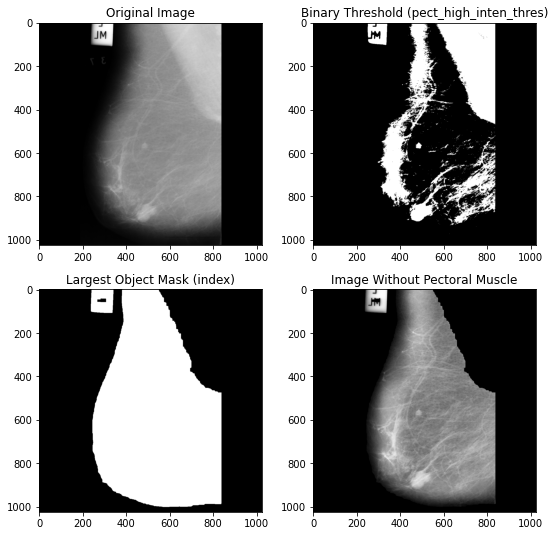

In [16]:
# @title **Pectoral removal segmentation** { display-mode: "form", run: "auto"}

# up to 322
image = "mdb005.pgm" #@param ["mdb001.pgm", "mdb002.pgm", "mdb003.pgm", "mdb004.pgm", "mdb005.pgm"] {allow-input: true}

img = cv2.imread(path+image, cv2.IMREAD_UNCHANGED)

threshold = 150 #@param {type:"slider", min:50, max:250, step:10}

_, image_wo_pectoral, _ = pectoral_removal(img, pect_high_inten_thres = threshold)

## Metrics for assited segmentation

### Filter results

Median filter. PSNR:  45.898602673531535 . MSE:  1.493391990661621
Gaussian filter. PSNR:  45.169184514021275 . MSE:  1.7665081024169922
Wiener filter. PSNR:  30.830785934176625 . MSE:  47.96842861175537
Median filter selected.


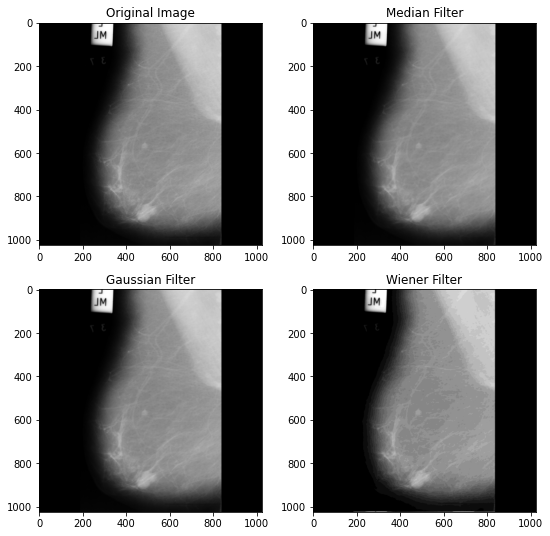

In [17]:
# Filter selection
f, p, m = filter_selection(img, plot=True)

### Elbow curves (for k selection in k-means)

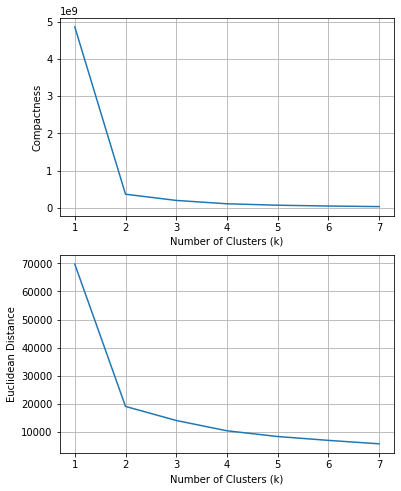

In [32]:
Nc = range(1, 8)
score = []
for K in Nc:
  _, ret = k_means(image_wo_pectoral, K)
  score.append(ret)

fig, axs = plt.subplots(2, 1, figsize=(6,8))
axs[0].plot(Nc,score)
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('Compactness')
axs[0].grid(True)
axs[1].plot(Nc,np.sqrt(score))
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('Euclidean Distance')
axs[1].grid(True)
plt.show()

### Segmentation
* negative value: k-means
* positive value: threshold
* zero value: pect_high_inten_thres (previous)

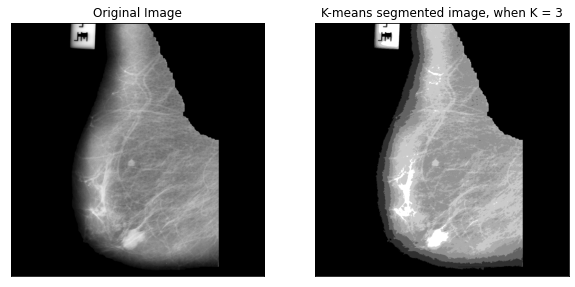

In [40]:
# seg_idx: negative k-means
#          positive threshold
#          zero pect_high_inten_thres

seg_idx =  -3#@param {type:"integer"}
if seg_idx == 0:
  seg_idx = threshold

r_img = mamm_segmentation(image_wo_pectoral, seg_idx = seg_idx)